In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import re
import itertools
import os
import pandas as pd
import numpy as np

In [2]:
from src import etl

### EDA

In [3]:
apps = os.listdir('data')

In [4]:
num_apis = []
unique_apis = []
num_methods = []
unique_methods = []
most_used_package = []

In [5]:
for app in apps: #extract features
    smalis = etl.smalis_from_paths(etl.get_smali_paths('data/'+app))
    n, u = etl.num_api(smalis)
    num_apis.append(n)
    unique_apis.append(u)
    n, u = etl.num_method(smalis)
    num_methods.append(n)
    unique_methods.append(u)
    most_used_package.append(etl.most_used_package(smalis))

In [19]:
df = pd.DataFrame({
    'apps':apps,
    'num_api':num_apis,
    'unique_api':unique_apis,
    'num_method':num_methods,
    'unique_method':unique_methods,
    'most_used_package':most_used_package,
    'malware': [0]*len(most_used_package)
})
df = df[df['apps']!='.DS_Store']

In [20]:
df.shape

(25, 7)

In [21]:
df.describe()

,num_api,unique_api,num_method,unique_method,malware
count,25.000000,25.000000,25.000000,25.000000,25.0
mean,88235.360000,36530.280000,26214.360000,24828.840000,0.0
std,63747.546225,25340.083678,18633.786178,17563.413408,0.0
min,108.000000,59.000000,58.000000,58.000000,0.0
25%,31663.000000,15580.000000,10764.000000,10543.000000,0.0
50%,76891.000000,29547.000000,22614.000000,20994.000000,0.0
75%,138248.000000,58157.000000,42108.000000,40180.000000,0.0
max,187753.000000,78642.000000,58369.000000,53831.000000,0.0


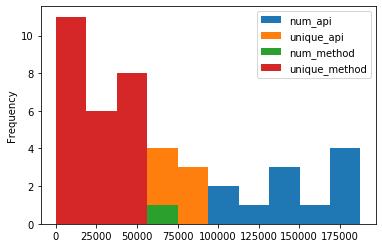

In [40]:
df.drop('malware',1).plot.hist()

In [23]:
df.most_used_package.value_counts()

Ljava/lang/StringBuilder;        19
Landroid/os/Parcel;               4
Lcom/om/mirror/Mirror;            1
Lcom/deluxeware/game/GameLib;     1
Name: most_used_package, dtype: int64

### train

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix

In [29]:
X = df.drop('malware', 1)
y = df.malware

In [32]:
cat_feat = ['most_used_package']
cat_trans = Pipeline(steps=[
    ('onehot', OneHotEncoder())
    ])

In [36]:
pre = ColumnTransformer(transformers=[('cat', cat_trans,cat_feat)])

In [38]:
pipe = Pipeline(steps=[('preprocessor', pre),
                       ('clf', LogisticRegression())
                       ])
pipe.fit(X,y)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
fn/()

In [27]:
clf = LogisticRegression().fit(X, y)
clf.predict()

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: could not convert string to float: 'Ljava/lang/StringBuilder;'

### GRAPH

In [ ]:
G = nx.Graph()
api_id = {}
current_id = 0

G.add_node('helloworld', node_type = 'app')

smalis = smalis_from_paths(get_smali_paths('data/helloworld'))

nx.neighbors(G, 'helloworld')

A = nx.adjacency_matrix(G.nodes.node_type('api'))
print(A.todense()[0])

for smali in smalis:
    apis = find_apis(smali)
    for call in apis:
        if call not in G:
            G.add_node(call, node_type = 'api')
            G.add_edge('helloworld', call)

In [70]:
G = nx.Graph()

In [71]:
node_num = 0

In [72]:
blocks = re.findall( '\.method([\S\s]*?)\.end method', text)

In [73]:
for block in blocks:
    same_block = []
    for line in block.split('\n'):
        if re.search( '^(invoke\-.*)\)V', line.strip()):
            G.add_node(node_num)
            same_block.append(node_num)
            node_num += 1
            print(re.search( '^(invoke\-.*)\)V', line.strip()).group())
    for pair in itertools.product(same_block, repeat=2):
        G.add_edge(pair[0], pair[1])

invoke-direct {p0}, Landroid/support/v7/app/AppCompatActivity;-><init>()V
invoke-super {p0, p1}, Landroid/support/v7/app/AppCompatActivity;->onCreate(Landroid/os/Bundle;)V
invoke-virtual {p0, v0}, Lcom/ethicalhackx/myapplication/MainActivity;->setContentView(I)V


/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


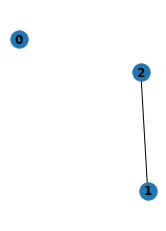

In [74]:
plt.subplot(121)
nx.draw(G, with_labels=True, font_weight='bold')

In [31]:
nx.adjacency_matrix(G).todense()

matrix([[0., 0.],
        [0., 0.]])